# Install libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling as pf

from io import BytesIO
from pandas.io import sql
from sqlalchemy import create_engine
from mysql import connector
from google.cloud import storage
from google.cloud import bigquery

%matplotlib inline
import matplotlib.pyplot as plt
#plt.switch_backend('agg')

pd.set_option('display.max_columns', None)

# Configure connection with Cloud SQL

In [2]:
user='ea-developer'
host='35.205.32.16'
port='3306'
db='ea_datalake'
database_connection = create_engine('mysql+mysqlconnector://{0}:@{1}:{2}/{3}'.format(user, host, port, db))

# Configure connection with Bigquery

In [3]:
bigquery_client = bigquery.Client()

# Configure connection with Cloud Storage

In [4]:
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = 'ea-datalake-dev'

In [5]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))
    
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    blobs = bucket.list_blobs()

    for blob in blobs:
        print(blob.name)

# Exploratory Data Analysis

#### Focused on the different languages of the players speak

In [6]:
df_players = pd.read_sql('SELECT * FROM ea_players_language', con=database_connection)

### Top Nationalities
United Kingdom is the nationallity with most players associated

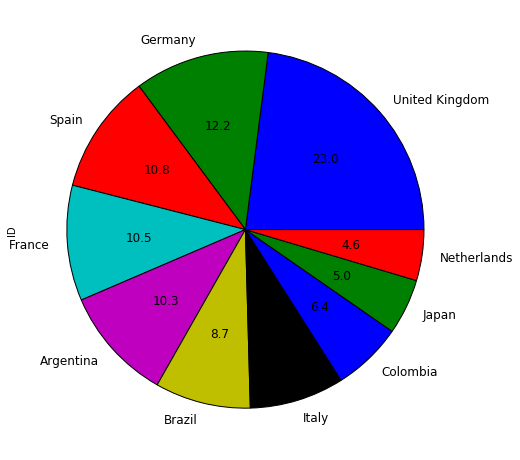

In [7]:
nationalities = df_players.groupby("Nationality").ID.count().sort_values(ascending=False).head(10)
nationalities.plot.pie(autopct='%.1f', fontsize=12, figsize=(8, 8))
plt.show()

### Top languages

United Kingdom is the top one nationality, however, Spanish is the most frequent as primary language

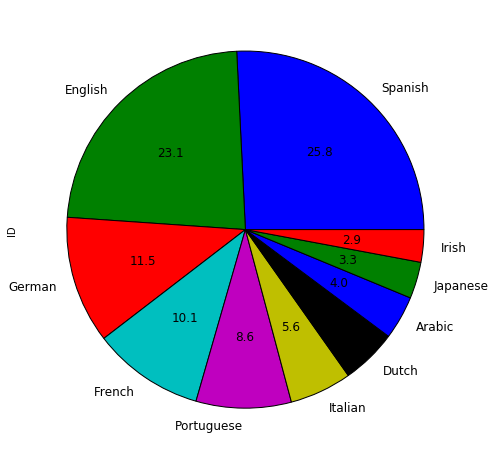

In [8]:
languages = df_players.groupby("Primary Language").ID.count().sort_values(ascending=False).head(10)
languages.plot.pie(autopct='%.1f', fontsize=12, figsize=(8, 8))
plt.show()

Filter out languages with a low number of registers, in order to keep just the languages with a statiscally relevant number of representants

In [9]:
df_top_lang = df_players.groupby("Primary Language").ID.count().reset_index()
df_top_lang = df_top_lang[df_top_lang.ID>=100]
top_lang = list(df_top_lang['Primary Language'])
df_languages_top = df_players[df_players['Primary Language'].isin(top_lang)]

Load data from Cloud SQL Database

In [10]:
df_languages_top.to_sql(con=database_connection, name='ea_players_language_top', if_exists='replace',index=False)

### Which LANGUAGE is present in more CLUBs?

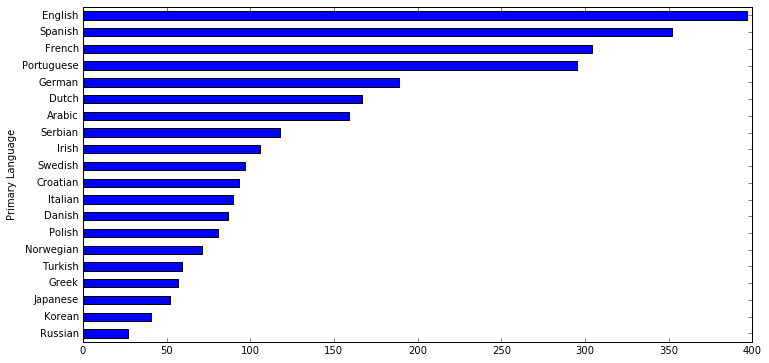

In [11]:
df_languages_top.groupby("Primary Language").Club.nunique().sort_values(ascending=True).reset_index().\
    plot.barh(x='Primary Language',use_index=True,legend=False,figsize=(12,6))    
plt.show()

### What is the PREFERRED POSITION by LANGUAGE?

In [12]:
preferred = df_languages_top.groupby(['Primary Language','Preferred Position']).ID.count().\
    sort_values(ascending=False).reset_index().rename(columns = {'ID':'Freq'})

preferred.loc[preferred.reset_index().groupby(['Primary Language'])['Freq'].idxmax()]

,Primary Language,Preferred Position,Freq
61,Arabic,CB,68
175,Croatian,CB,20
76,Danish,CB,58
38,Dutch,CB,112
1,English,CB,496
20,French,ST,213
14,German,CB,244
187,Greek,CB,17
62,Irish,CB,66
32,Italian,CB,135


### Which LANGUAGES have the higher POTENTIAL based on players stats?

The Greek and Serbian speaker players have the higher potencial

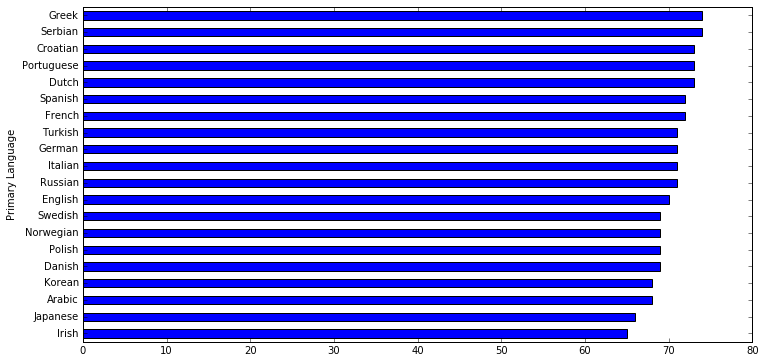

In [13]:
df_languages_top.groupby("Primary Language").Potential.median().sort_values(ascending=True).reset_index().\
    plot.barh(x='Primary Language',use_index=True,legend=False,figsize=(12,6))    
plt.show()

### Which LANGUAGES have the higher OVERALL based on players stats?

The portuguese speaker players have the higher overall on average

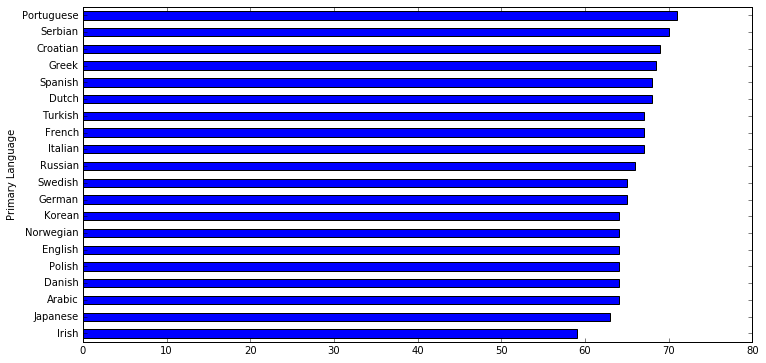

In [14]:
df_languages_top.groupby("Primary Language").Overall.median().sort_values(ascending=True).reset_index().\
    plot.barh(x='Primary Language',use_index=True,legend=False,figsize = (12,6))    
plt.show()

### What is the median AGE for each LANGUAGE?

The dutch speaker players are the youngest on average

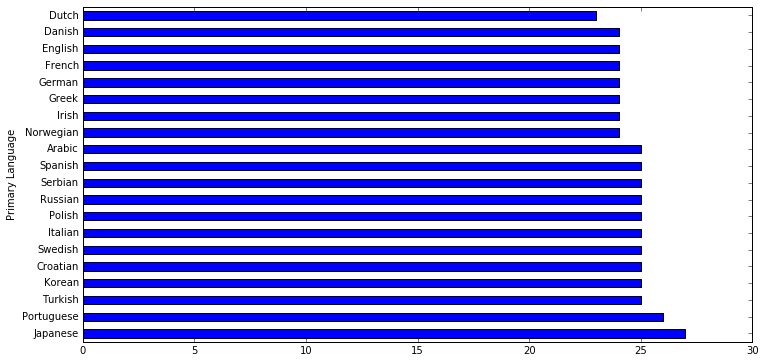

In [15]:
df_languages_top.groupby("Primary Language").Age.median().sort_values(ascending=False).reset_index().\
    plot.barh(x='Primary Language',use_index=True,legend=False,figsize = (12,6))    
plt.show()

### What is the average WAGE by LANGUAGE?

The players who speak Croatian have the highest wage on average

In [16]:
df_languages_top.groupby("Primary Language").Wage.mean().sort_values(ascending=False).apply(lambda x: '%.0f' % x)

Primary Language
Croatian      24546
Portuguese    17233
Serbian       16707
Russian       16577
Dutch         15313
Italian       14353
French        14280
Turkish       13615
Spanish       13006
German        10892
Arabic        10299
English        9916
Greek          8915
Danish         7202
Polish         7122
Swedish        6374
Irish          5882
Norwegian      4060
Japanese       4038
Korean         3685
Name: Wage, dtype: object

### Which is the LANGUAGE associated to the higher VALUE players on average?

The players who speak Croatian are the most valued on average

In [17]:
df_languages_top.groupby("Primary Language").Value.mean().sort_values(ascending=False).apply(lambda x: '%.0f' % x)

Primary Language
Croatian      5165046
Portuguese    4073830
Serbian       3735159
Dutch         3524551
French        3230223
Spanish       3067250
Greek         3045236
Italian       2694292
German        2317796
Turkish       2294845
Russian       1973443
Arabic        1734456
Danish        1596257
Polish        1496399
English       1367656
Swedish       1343757
Norwegian      971556
Korean         946488
Japanese       798923
Irish          682578
Name: Value, dtype: object